# **Waze Project**

# **Build a binomial logistic regression model**

**The goal** is to build a binomial logistic regression model that predicts user's churn and evaluate the model's performance.
<br/>

*This activity has three parts:*

**Part 1:** Data Preprocessing & Checking Model Assumptions

**Part 2:** Model Building and Evaluation

**Part 3:** Interpreting Model Results

### **Imports and data loading**

In [1]:
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Logistic Regression & Confusion Matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
# Load the dataset by running this cell
df = pd.read_csv('waze_dataset.csv')

In [3]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


### **Data Preprocessing**

**Note:**

From our previous phases we know:
- data has  700 missing values in our outcome feature (label).
- data has no duplicates
- churn rate correlates with distance driven per driving day in the last month
- these columns have outliers:
    * `sessions`
    * `drives`
    * `total_sessions`
    * `total_navigations_fav1`
    * `total_navigations_fav2`
    * `driven_km_drives`
    * `duration_minutes_drives`

we will start by removing the ID column since you don't need this information for your analysis.

In [4]:
# Drop `ID` column
df = df.drop('ID', axis=1)

In [5]:
# Drop rows with missing data in `label` column
df = df.dropna(subset=['label'])

#### **Impute outliers**

we will impute the outlying values for columns we stated above that contains outliers with the **95th percentile** of each column.

In [6]:
# Impute outliers
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

In [7]:
# Check new summary statistics
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000


### **Feature Enigneering**

#### **`km_per_driving_day`**

Since we know that churn rate correlates with distance driven per driving day in the last month. It might be helpful to engineer a feature that captures this information.

In [8]:
# 1. Create `km_per_driving_day` column
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Call `describe()` on the new column
df['km_per_driving_day'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.675616e+02
50%      3.237524e+02
75%      7.415597e+02
max               inf
Name: km_per_driving_day, dtype: float64

Note that some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

Lets fix this problem.

In [9]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14299.000000
mean       567.010426
std        970.136935
min          0.000000
25%        136.168003
50%        273.301012
75%        543.473676
max       8898.716275
Name: km_per_driving_day, dtype: float64

#### **`professional_driver`**

We will Create a new binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers. In this scenario, domain knowledge and intuition are used to determine these deciding thresholds, but ultimately they are arbitrary.

In [10]:
# Create `professional_driver` column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

Lets perform a quick inspection of the new variable.

In [11]:
# 1. Check count of professionals and non-professionals
print(df['professional_driver'].value_counts())

# 2. Check in-class churn rate
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

0    11811
1     2488
Name: professional_driver, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: label, dtype: float64

The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.

### **Encode categorical variables**

we will:

For `label` column:

* `retained` -> `0`

* `churned` => `1`

For `device2` column:

* `Android` -> `0`
* `iPhone` -> `1`

In [12]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


In [13]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


### **Check Model assumptions**
The following are the assumptions for logistic regression:

* Independent observations (This refers to how the data was collected.)

* No extreme outliers

* Little to no multicollinearity among X predictors

* Linear relationship between X and the **logit** of y

For the first assumption, we can assume that observations are independent for this project.

The second assumption has already been addressed.

The last assumption will be verified after modeling.

So we will check the 3rd assumpution

#### **Collinearity**

we will plot a correlation heatmap.

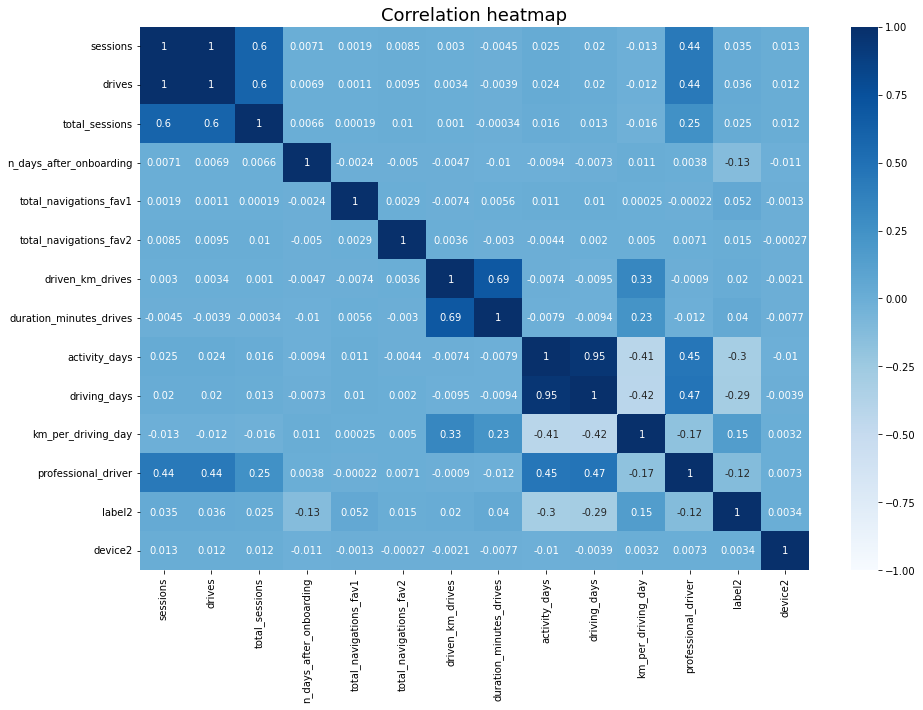

In [14]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='Blues')
plt.title('Correlation heatmap', fontsize=18)
plt.show();

If there are predictor variables that have a Pearson correlation coefficient value greater than the **absolute value of 0.7**, these variables are strongly multicollinear. Therefore, only one of these variables should be used in your model.

**Note:** 0.7 is an arbitrary threshold. Some industries may use 0.6, 0.8, etc.

We can see that *`sessions` and `drives`: 1.0* are multicollinear with each other, and *`driving_days` and `activity_days`: 0.95*  also

so we will need to drop one of them for each combination

### **Model building**

#### **Feature selection**

we will drop the following variables and assign the results to `X`:

* `label` (this is the target)
* `label2` (this is the target)
* `device` (this is the non-binary-encoded categorical variable)
* `sessions` (this had high multicollinearity)
* `driving_days` (this had high multicollinearity)

In [15]:
# Isolate predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

# Isolate target variable
y = df['label2']

#### **Split the data**

In [16]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [17]:
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
152,108,186.192746,3116,243,124,8898.716275,4668.180092,24,593.247752,1,1
11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0,1
10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0,0
669,108,455.439492,2320,11,4,6566.424830,4558.459870,18,410.401552,1,1
8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0,1


we will add `penalty = 'none'` since we didnt't scale our predictors.

In [18]:
model = LogisticRegression(penalty='none', max_iter=400)

# Fit model
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
pd.Series(model.coef_[0], index=X.columns)

drives                     0.001915
total_sessions             0.000326
n_days_after_onboarding   -0.000406
total_navigations_fav1     0.001232
total_navigations_fav2     0.000936
driven_km_drives          -0.000014
duration_minutes_drives    0.000109
activity_days             -0.106195
km_per_driving_day         0.000015
professional_driver       -0.001527
device2                   -0.001067
dtype: float64

In [20]:
model.intercept_

array([-0.00174019])

#### **Check final assumption**
Verify the linear relationship between X and the estimated log odds.

In [21]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93937724, 0.06062276],
       [0.62141337, 0.37858663],
       [0.7640656 , 0.2359344 ],
       ...,
       [0.91892457, 0.08107543],
       [0.85056565, 0.14943435],
       [0.93497748, 0.06502252]])

In [22]:
# Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

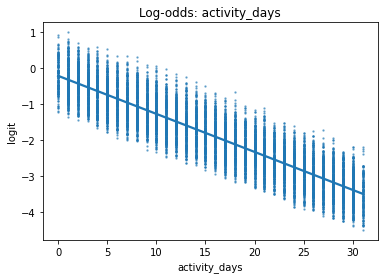

In [23]:
# regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

### **Results and evaluation**

In [24]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

In [25]:
# Score the model (accuracy) on the test data
model.score(X_test, y_test)

0.8237762237762237

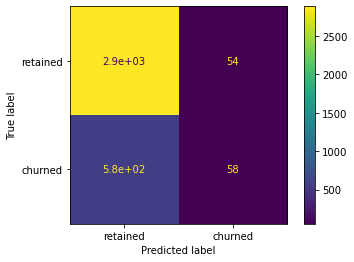

In [26]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained', 'churned'])
disp.plot();

In [27]:
# Create a classification report
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.52      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



**Note:** The model has mediocre precision and very low recall, which means that it makes a lot of false negative predictions and fails to capture users who will churn and has an accuracy of **82%**.

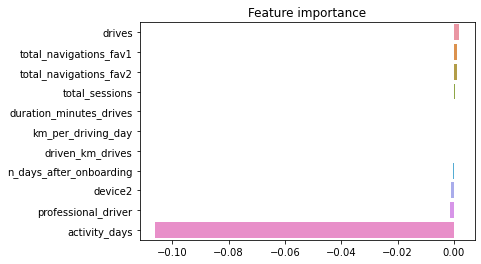

In [28]:
# Plot the feature importances
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');

### **Conclusion**

- `activity_days` was by far the most important feature in the model. It had a negative correlation with user churn. This was not surprising, as this variable was very strongly correlated with `driving_days`, which was known from EDA to have a negative correlation with churn._

- Do i recommend that Waze use this model ? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value._


- New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, one of the engineered features (`professional_driver`) was the third-most-predictive predictor. It could also be helpful to scale the predictor variables, and/or to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._


- It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs._

### Summary

Share an executive summary with my team [link](https://github.com/yousefayman2003/Portfolio-Projects/tree/main/Data-Science/Waze/regression_analysis/executive_summary.pdf)